In [ ]:
# Import required packages
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
import random

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed
seed = 10
# CPU seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# GPU seed
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [ ]:
# Transforms
transform = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)), # ResNet18 expects 224x224 images
        transforms.RandomHorizontalFlip(), # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Path to kaggle CIFAKE dataset
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

# Load datasets
train_data = datasets.ImageFolder(os.path.join(path, "train"), transform["train"])
test_data = datasets.ImageFolder(os.path.join(path, "test"), transform["test"])

# Use subset of data
train_data, _ = random_split(train_data, [30000,70000], torch.Generator().manual_seed(seed))
test_data, _ = random_split(test_data, [7500,12500], torch.Generator().manual_seed(seed))
train_data, val_data = random_split(train_data, [24000, 6000], torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=2)

In [4]:
# Model setup
model = models.resnet18(weights=None)  # train from random weights
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [5]:
# Train and collect metrics per epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float("inf")
epochs = 20
patience = 3
epochs_without_improvement = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Accuracy calculation (BCEWithLogitsLoss)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            labels = labels.float().unsqueeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy calculation for validation
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()
            val_correct += (preds == labels.long()).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}: "
          f"Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch} epochs. Model at epoch {epoch - patience} has been saved for use.")
            break

# Load best model
model.load_state_dict(torch.load("best_model.pth"))

Epoch 0: Train Loss=0.3946, Train Acc=0.8235, Val Loss=0.2847, Val Acc=0.8902
Epoch 1: Train Loss=0.2832, Train Acc=0.8816, Val Loss=0.2334, Val Acc=0.9048
Epoch 2: Train Loss=0.2375, Train Acc=0.9050, Val Loss=0.2078, Val Acc=0.9192
Epoch 3: Train Loss=0.2173, Train Acc=0.9146, Val Loss=0.2211, Val Acc=0.9108
Epoch 4: Train Loss=0.1972, Train Acc=0.9247, Val Loss=0.1588, Val Acc=0.9395
Epoch 5: Train Loss=0.1801, Train Acc=0.9309, Val Loss=0.1488, Val Acc=0.9433
Epoch 6: Train Loss=0.1660, Train Acc=0.9367, Val Loss=0.1846, Val Acc=0.9292
Epoch 7: Train Loss=0.1515, Train Acc=0.9413, Val Loss=0.1637, Val Acc=0.9365
Epoch 8: Train Loss=0.1410, Train Acc=0.9454, Val Loss=0.1437, Val Acc=0.9443
Epoch 9: Train Loss=0.1353, Train Acc=0.9486, Val Loss=0.1496, Val Acc=0.9453
Epoch 10: Train Loss=0.1242, Train Acc=0.9519, Val Loss=0.1367, Val Acc=0.9493
Epoch 11: Train Loss=0.1183, Train Acc=0.9527, Val Loss=0.1305, Val Acc=0.9525
Epoch 12: Train Loss=0.1076, Train Acc=0.9595, Val Loss=0.1477

<All keys matched successfully>

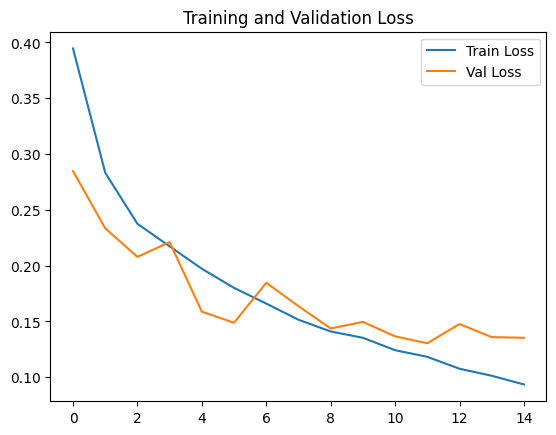

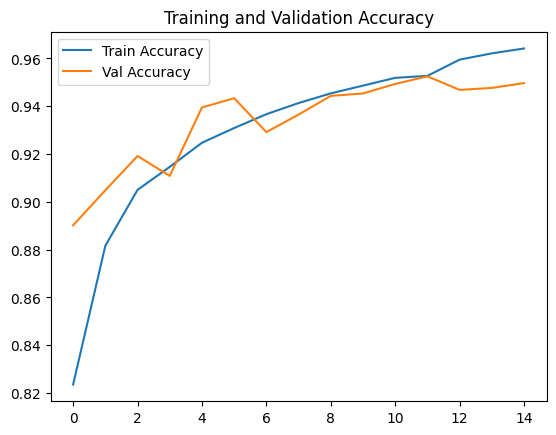

In [6]:
# Plot loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

In [7]:
# Performance metrics and confusion matrix
def Evaluation(data_loader, dataset):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()
            y_pred.extend(preds.cpu().numpy().flatten())
            y_true.extend(labels.cpu().numpy())

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"{dataset} Accuracy: {acc:.4f}")
    print(f"{dataset} Precision: {prec:.4f}")
    print(f"{dataset} Recall: {rec:.4f}")
    print(f"{dataset} F1 Score: {f1:.4f}")

    # Confusion matrix plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{dataset} Confusion Matrix")
    plt.show()

Validation Accuracy: 0.9515
Validation Precision: 0.9375
Validation Recall: 0.9678
Validation F1 Score: 0.9524


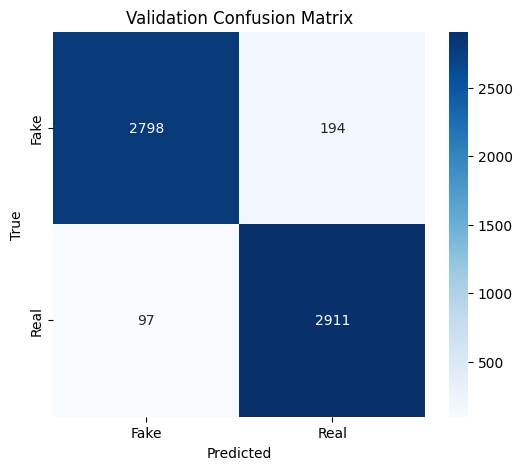

In [8]:
Evaluation(val_loader, "Validation")

Test Accuracy: 0.9487
Test Precision: 0.9378
Test Recall: 0.9606
Test F1 Score: 0.9491


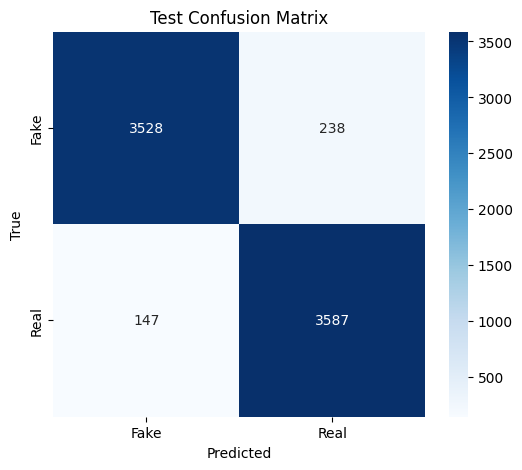

In [9]:
Evaluation(test_loader, "Test")

In [ ]:
# Adapted from: https://github.com/jacobgil/pytorch-grad-cam with help of chatgpt
# Grad-CAM logic based on averaging gradients over feature maps
# and weighting convolutional activations

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

def generate_gradcam(model, input_tensor, target_class=None, target_layer_name='layer4'):
    """
    Generate Grad-CAM heatmap for a given input_tensor and model.
    - model: trained model (ResNet-18)
    - input_tensor: a single preprocessed image (shape [3, H, W])
    - target_class: 0 or 1 for binary classification; None to use predicted class
    - target_layer_name: typically 'layer4' for ResNet-18
    """
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(next(model.parameters()).device)

    # Store gradients and activations
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks to the target layer
    target_layer = dict(model.named_modules())[target_layer_name]
    fwd_hook = target_layer.register_forward_hook(forward_hook)
    bwd_hook = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    if target_class is None:
        target_class = int(torch.sigmoid(output).item() > 0.5)
    loss = output[0, 0] if target_class == 1 else -output[0, 0]

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Get hooked data
    grads = gradients[0]
    acts = activations[0]

    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * acts).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().detach().numpy()
    cam -= cam.min()
    cam /= cam.max()

    # Remove hooks
    fwd_hook.remove()
    bwd_hook.remove()

    return cam

def show_gradcam_on_image(img_tensor, cam, alpha=0.5):
    """
    Overlay Grad-CAM heatmap on the original image.
    - img_tensor: original image tensor (normalized, shape [3, H, W])
    - cam: heatmap returned from generate_gradcam
    """
    # Unnormalize image (ImageNet)
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32) / 255
    heatmap = heatmap[..., ::-1]

    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(cam, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

True Label: 1, Predicted: 1 (Probability: 1.00)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


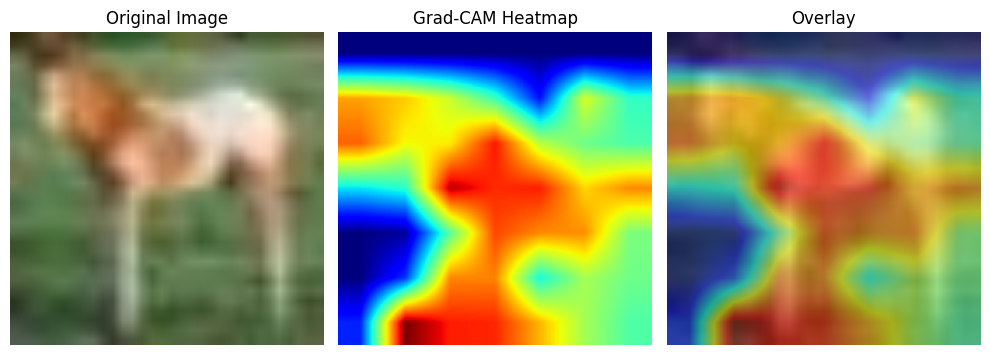

True Label: 1, Predicted: 1 (Probability: 1.00)


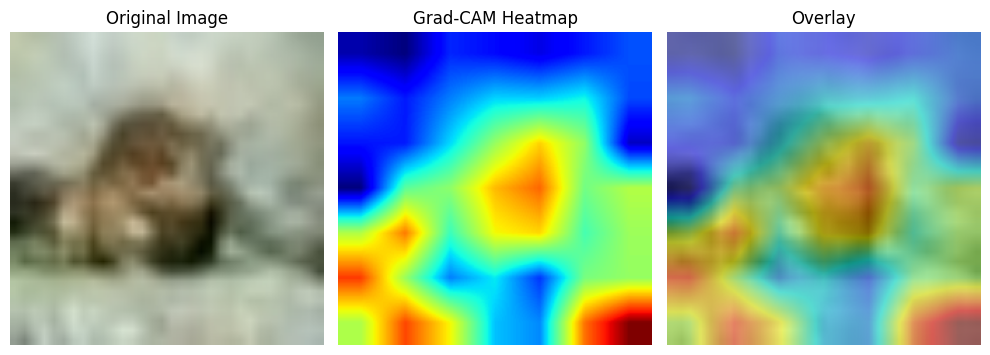

True Label: 0, Predicted: 0 (Probability: 0.01)


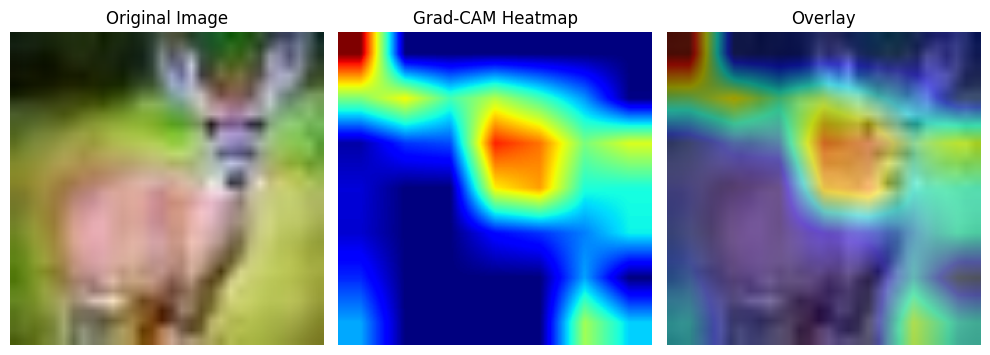

True Label: 0, Predicted: 0 (Probability: 0.00)


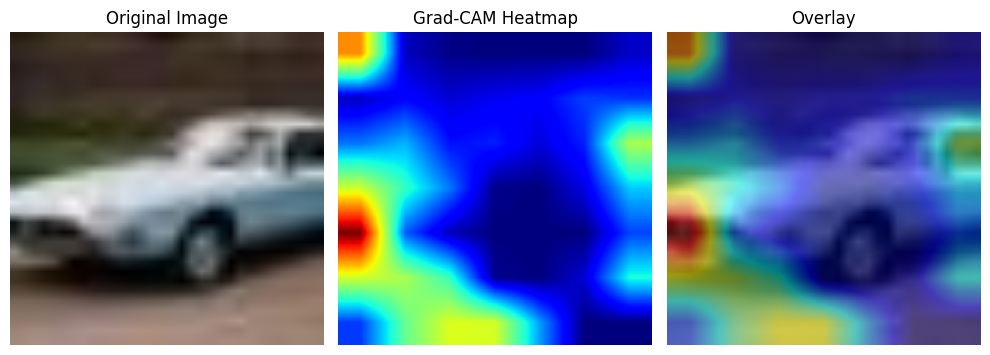

True Label: 0, Predicted: 0 (Probability: 0.02)


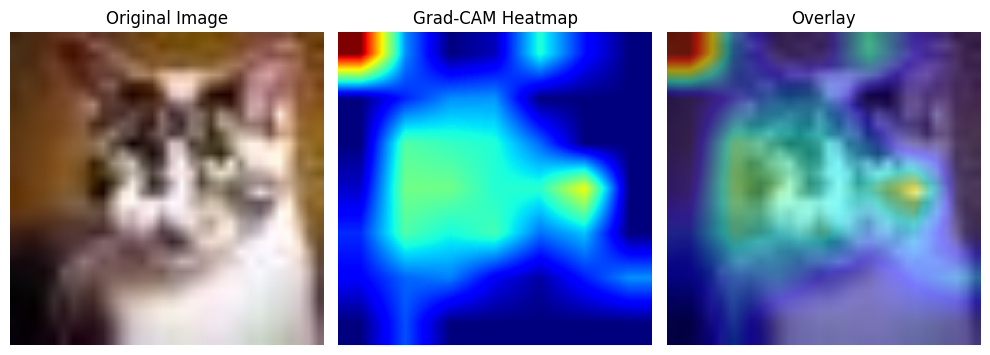

In [ ]:
image, label = next(iter(test_loader))

# Sample of images to portray patterns clearly for presentation purposes
samples = [1, 2, 3, 12, 13]
for i in samples:
    img_tensor = image[i].to(device)

    with torch.no_grad():
      output = model(img_tensor.unsqueeze(0))
      prob = torch.sigmoid(output).item()
      pred_class = int(prob > 0.5)
      print(f"True Label: {label[i].item()}, Predicted: {pred_class} (Probability: {prob:.2f})")


    cam = generate_gradcam(model, img_tensor, target_layer_name='layer4')
    show_gradcam_on_image(img_tensor, cam)
